## Importing required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
import imutils # !pip install imutils
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.optimizers import SGD
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.regularizers import l1,l2
import os
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Creating X and Y arrays

In [2]:
x = []
y = []
for i in range(0,16):
    for j in range(1,21):
        a = os.path.isfile('allData/dataset/'+str(i)+'/'+str(j)+'.png')
        if a :
            image = cv2.imread('allData/dataset/'+str(i)+'/'+str(j)+'.png', 0)
            img_resized = cv2.resize(255-image, (28,28), interpolation=cv2.INTER_AREA)
            unrolled = img_resized.ravel()
            x.append(unrolled)
            y.append(i)

In [3]:
# Converting x and y variables to numpy arrays
x = np.array(x)
y = np.array(y)

In [4]:
# Shapes of x and y arrays
print(x.shape)
print(y.shape)

(320, 784)
(320,)


## Preprocessing

### 1) Splitting

In [5]:
# We divide the dataset into 3 separate parts as train test and validation sets.

In [6]:
# train = %70 and test = %30 of overall dataset
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.3, random_state=123)

In [7]:
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=123)

### 2) Normalization and Reshaping

In [8]:
# Reshape data

In [9]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) 

In [10]:
input_shape = (28, 28, 1)

In [11]:
# We convert the values held by our variables to float
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [12]:
# Normalization for RGB

In [13]:
x_train /= 255
x_val /= 255
x_test /= 255

In [14]:
print("x_train shape: ",x_train.shape)

x_train shape:  (224, 28, 28, 1)


In [15]:
print("y_train shape: ",y_train.shape)

y_train shape:  (224,)


In [16]:
# one hot encoding
y_train = to_categorical(y_train, num_classes = 16)

In [17]:
# splitting for fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=123)

In [18]:
# Shapes of x_train, x_test, y_train and y_test
print("x_train shape",x_train.shape)
print("x_test shape",x_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

x_train shape (201, 28, 28, 1)
x_test shape (23, 28, 28, 1)
y_train shape (201, 16)
y_test shape (23, 16)


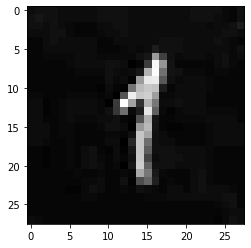

In [19]:
# See some image
plt.imshow(x_train[2][:,:,0],cmap='gray')
plt.show()

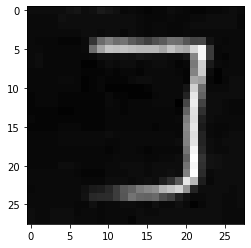

In [20]:
plt.imshow(x_train[0][:,:,0],cmap='gray')
plt.show()

## Data augmentation is done to increase the data

In [21]:
data_generator = ImageDataGenerator(
    rescale = 1./255, 
    shear_range = 0.2, 
    zoom_range = 0.2,
    validation_split = 0.25,
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=True,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,  # divide each input by its std
    zca_whitening=True,  # dimesion reduction
    rotation_range=0.5,  # randomly rotate images in the range 5 degrees
    width_shift_range=0.5,  # randomly shift images horizontally 5%
    height_shift_range=0.5,  # randomly shift images vertically 5%
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True     # randomly flip images
)

In [22]:
# The location of the data to be used
path = 'allData/dataset'

In [23]:
# Train data
train = data_generator.flow_from_directory(
    path, 
    class_mode = 'categorical',
    target_size = (40, 40),
    subset='training',
    color_mode = 'grayscale',
    batch_size = 10,
    shuffle = True,
    seed = 123
)

Found 240 images belonging to 16 classes.


In [24]:
# Validation data
valid = data_generator.flow_from_directory(
    path, 
    class_mode = 'categorical',
    target_size = (40, 40), 
    subset='validation',
    color_mode = 'grayscale',
    batch_size = 10,
    shuffle = True,
    seed = 123
)

Found 80 images belonging to 16 classes.


## Creating a CNN model

In [25]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [26]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (40,40,1)))

# kernel_regularizer=l1(0.01),activity_regularizer=l2(0.01)

model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# model.add(Dropout(0.25))

# fully connected

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
# model.add(Dropout(0.5))
model.add(Dense(16, activation = "softmax"))

#model.add(BatchNormalization())

In [27]:
# (I didn't use kernel_regularizer and BatchNormalization to get better result from model)

In [28]:
# Define the optimizer
optimizer = Adam(lr = 5e-4)

In [29]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [30]:
epochs = 100
batch_size = 10

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 128)        0

In [32]:
# fit the model
hist = model.fit_generator(train,validation_data=valid,epochs=100 ,verbose=1,validation_steps = 10)

Epoch 1/100
24/24 [==============================] - 4s 166ms/step - loss: 2.8196 - accuracy: 0.0625 - val_loss: 2.7706 - val_accuracy: 0.0750
Epoch 2/100
24/24 [==============================] - 0s 18ms/step - loss: 2.7652 - accuracy: 0.0542
Epoch 3/100
24/24 [==============================] - 0s 19ms/step - loss: 2.7629 - accuracy: 0.0667
Epoch 4/100
24/24 [==============================] - 0s 20ms/step - loss: 2.7404 - accuracy: 0.0708
Epoch 5/100
24/24 [==============================] - 0s 18ms/step - loss: 2.7092 - accuracy: 0.0917
Epoch 6/100
24/24 [==============================] - 0s 18ms/step - loss: 2.6305 - accuracy: 0.1333
Epoch 7/100
24/24 [==============================] - 0s 18ms/step - loss: 2.5005 - accuracy: 0.1875
Epoch 8/100
24/24 [==============================] - 0s 18ms/step - loss: 2.4951 - accuracy: 0.1417
Epoch 9/100
24/24 [==============================] - 0s 18ms/step - loss: 2.3684 - accuracy: 0.1792
Epoch 10/100
24/24 [==============================] - 0s 

24/24 [==============================] - 0s 18ms/step - loss: 0.7479 - accuracy: 0.7667
Epoch 79/100
24/24 [==============================] - 0s 18ms/step - loss: 0.6664 - accuracy: 0.7708
Epoch 80/100
24/24 [==============================] - 0s 18ms/step - loss: 0.6448 - accuracy: 0.7708
Epoch 81/100
24/24 [==============================] - 0s 18ms/step - loss: 0.6947 - accuracy: 0.7583
Epoch 82/100
24/24 [==============================] - 0s 18ms/step - loss: 0.8006 - accuracy: 0.7792
Epoch 83/100
24/24 [==============================] - 0s 18ms/step - loss: 0.6802 - accuracy: 0.7750
Epoch 84/100
24/24 [==============================] - 0s 18ms/step - loss: 0.7682 - accuracy: 0.7542
Epoch 85/100
24/24 [==============================] - 0s 18ms/step - loss: 0.6670 - accuracy: 0.7708
Epoch 86/100
24/24 [==============================] - 0s 18ms/step - loss: 0.7509 - accuracy: 0.7625
Epoch 87/100
24/24 [==============================] - 0s 18ms/step - loss: 0.7319 - accuracy: 0.7125
Epo

In [33]:
# Calculate the accuracy
val_loss, val_accuracy = model.evaluate(valid)
print(val_loss,val_accuracy)

8/8 [==============================] - 0s 13ms/step - loss: 0.7851 - accuracy: 0.7625
0.7851147651672363 0.762499988079071


In [34]:
# Data visualization for train loss and train accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


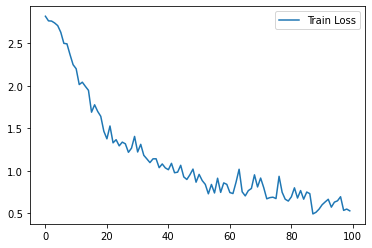

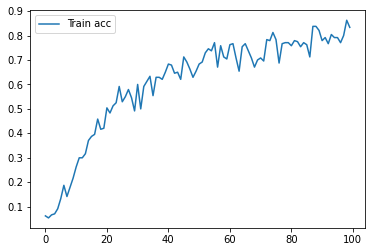

In [35]:
print(hist.history.keys())
plt.plot(hist.history["loss"], label = "Train Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.legend()
plt.show()

In [36]:
# train set classes
train.class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '8': 14,
 '9': 15}

In [37]:
label = (train.class_indices)
label

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '8': 14,
 '9': 15}

In [38]:
# prediction function that will understand the mathematical equation and make predictions using the model we created 
# and the cv2 library

In [39]:
def predict_image(image):

    plt.imshow(image, cmap = 'gray')
    image = cv2.resize(image,(40, 40))
    normalized = cv2.normalize(image, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    normalized = normalized.reshape((normalized.shape[0], normalized.shape[1], 1))
    y = np.asarray([normalized])
    prediction = np.argmax(model.predict(y))
    
    return prediction

In [40]:
# Code to distinguish and understand numbers and operators in a mathematical equation 
# written on paper using the cv2 library

1/1 [==============================] - 0s 16ms/step


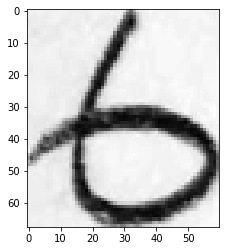

In [41]:
image = cv2.imread('2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
chars=[]

for c in cnts:

    (x, y, w, h) = cv2.boundingRect(c)

    if w*h>1200:
       
        roi = gray[y:y + h, x:x + w]
        chars.append(predict_image(roi))
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

In [42]:
# Show the mathematical equation

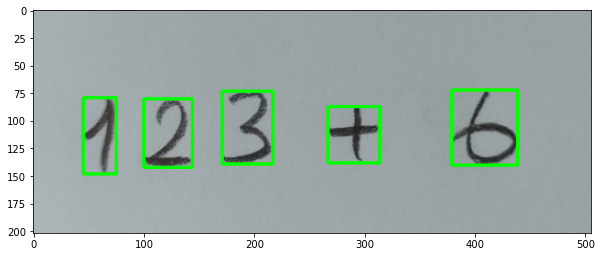

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(image)

In [44]:
# characters in the picture
chars

[4, 4, 4, 4, 4]

In [45]:
# We introduce the contents of 10, 11, 12, 13, 14 and 15 files to the label list.

In [46]:
labels=[i for i in train.class_indices]
print(labels)

['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']


In [47]:
labels[2] = "-"
labels[3] = "+"
labels[4] = "*"
labels[5] = "/"
labels[6] = "["
labels[7] = "]"

In [48]:
labels

['0',
 '1',
 '-',
 '+',
 '*',
 '/',
 '[',
 ']',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [49]:
equation = []
result = ""
for i in chars:
    equation.append(labels[i])
    result = ''.join(equation)

In [50]:
# Mathematical equation written in the photo

In [51]:
result

'*****'